# MTG Prices Gp Proj

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import time
import acquire
import prepare
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import requests

import util

pd.set_option('display.max_columns', None)

In [2]:
# How did he get it to just read the file name instead of the whole path?
df = pd.read_json('/Users/ultimate/codeup-data-science/scratchbook_for_current_gp_proj/Jason/default-cards-20220726090449.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70932 entries, 0 to 70931
Data columns (total 83 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   object               70932 non-null  object        
 1   id                   70932 non-null  object        
 2   oracle_id            70927 non-null  object        
 3   multiverse_ids       70932 non-null  object        
 4   mtgo_id              37227 non-null  float64       
 5   mtgo_foil_id         24259 non-null  float64       
 6   tcgplayer_id         60548 non-null  float64       
 7   cardmarket_id        59255 non-null  float64       
 8   name                 70932 non-null  object        
 9   lang                 70932 non-null  object        
 10  released_at          70932 non-null  datetime64[ns]
 11  uri                  70932 non-null  object        
 12  scryfall_uri         70932 non-null  object        
 13  layout               70932 non-

## Hypothesis Questions
- 1. **What’s the difference in card prices of prior printings vs its latest reprint?**
- 2. **How much of a difference between foil vs non-foil versions of a card from the same set?**
- 3. **How much does the rarity affect the cost**

In [3]:
α = 0.05

In [4]:
df

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,released_at,uri,scryfall_uri,layout,highres_image,image_status,image_uris,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,legalities,games,reserved,foil,nonfoil,finishes,oversized,promo,reprint,variation,set_id,set,set_name,set_type,set_uri,set_search_uri,scryfall_set_uri,rulings_uri,prints_search_uri,collector_number,digital,rarity,flavor_text,card_back_id,artist,artist_ids,illustration_id,border_color,frame,full_art,textless,booster,story_spotlight,edhrec_rank,penny_rank,prices,related_uris,all_parts,promo_types,arena_id,preview,security_stamp,produced_mana,watermark,frame_effects,loyalty,printed_name,card_faces,tcgplayer_etched_id,color_indicator,life_modifier,hand_modifier,printed_type_line,printed_text,content_warning,variation_of,flavor_name
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,2006-10-06,https://api.scryfall.com/cards/0000579f-7b35-4...,https://scryfall.com/card/tsp/157/fury-sliver?...,normal,True,highres_scan,{'small': 'https://c1.scryfall.com/file/scryfa...,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,c1d109bc-ffd8-428f-8d7d-3f8d7e648046,tsp,Time Spiral,expansion,https://api.scryfall.com/sets/c1d109bc-ffd8-42...,https://api.scryfall.com/cards/search?order=se...,https://scryfall.com/sets/tsp?utm_source=api,https://api.scryfall.com/cards/0000579f-7b35-4...,https://api.scryfall.com/cards/search?order=re...,157,False,uncommon,"""A rift opened, and our arrows were abruptly s...",0aeebaf5-8c7d-4636-9e82-8c27447861f7,Paolo Parente,[d48dd097-720d-476a-8722-6a02854ae28b],2fcca987-364c-4738-a75b-099d8a26d614,black,2003,False,False,True,False,5602.0,10436.0,"{'usd': '0.33', 'usd_foil': '4.50', 'usd_etche...",{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,2009-10-02,https://api.scryfall.com/cards/00006596-1166-4...,https://scryfall.com/card/zen/21/kor-outfitter...,normal,True,highres_scan,{'small': 'https://c1.scryfall.com/file/scryfa...,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,eb16a2bd-a218-4e4e-8339-4aa1afc0c8d2,zen,Zendikar,expansion,https://api.scryfall.com/sets/eb16a2bd-a218-4e...,https://api.scryfall.com/cards/search?order=se...,https://scryfall.com/sets/zen?utm_source=api,https://api.scryfall.com/cards/00006596-1166-4...,https://api.scryfall.com/cards/search?order=re...,21,False,common,"""We take only what we need to survive. Believe...",0aeebaf5-8c7d-4636-9e82-8c27447861f7,Kieran Yanner,[aa7e89ed-d294-4633-9057-ce04dacfcfa4],de0310d1-e97f-46e0-bc16-c980c2adedee,black,2003,False,False,True,False,13469.0,4743.0,"{'usd': '0.38', 'usd_foil': '7.22', 'usd_etche...",{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,[],NaN,NaN,98659.0,NaN,Spirit,en,2015-05-22,https://api.scryfall.com/cards/0000a54c-a511-4...,https://scryfall.com/card/tmm2/5/spirit?utm_so...,token,True,highres_scan,{'small': 'https://c1.scryfall.com/file/scryfa...,,0.0,Token Creature — Spirit,Flying,1,1,[W],[W],[Flying],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,[nonfoil],False,False,True,False,f7aa47c6-c1e2-4de5-9a68-4406d84bd6bb,tmm2,Modern Masters 2015 Tokens,token,https://api.scry

In [5]:
df = acquire.get_data(query_url = False)
print(df.shape)
df = prepare.prepare_dataframe(df)
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((40311, 60), (20155, 60), (20156, 60))

In [6]:
df.head(8)

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,legalities,games,reserved,foil,nonfoil,finishes,oversized,promo,reprint,variation,set_id,set,set_name,set_type,collector_number,digital,rarity,flavor_text,artist,border_color,frame,full_art,textless,booster,story_spotlight,edhrec_rank,penny_rank,prices,promo_types,security_stamp,produced_mana,watermark,frame_effects,loyalty,printed_name,color_indicator,life_modifier,hand_modifier,content_warning,flavor_name,usd,is_foil,is_etched,is_glossy
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,en,2006-10-06,normal,True,highres_scan,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,c1d109bc-ffd8-428f-8d7d-3f8d7e648046,tsp,Time Spiral,expansion,157,False,uncommon,"""A rift opened, and our arrows were abruptly s...",Paolo Parente,black,2003,False,False,True,False,5608.0,10402.0,"{'usd': '0.33', 'usd_foil': '4.50', 'usd_etche...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.33,True,False,False
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,en,2009-10-02,normal,True,highres_scan,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,eb16a2bd-a218-4e4e-8339-4aa1afc0c8d2,zen,Zendikar,expansion,21,False,common,"""We take only what we need to survive. Believe...",Kieran Yanner,black,2003,False,False,True,False,13482.0,4743.0,"{'usd': '0.37', 'usd_foil': '7.22', 'usd_etche...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.37,True,False,False
2,0000a54c-a511-4925-92dc-01b937f9afad,Spirit,en,2015-05-22,token,True,highres_scan,,0.0,Token Creature — Spirit,Flying,1,1,[W],[W],[Flying],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,[nonfoil],False,False,True,False,f7aa47c6-c1e2-4de5-9a68-4406d84bd6bb,tmm2,Modern Masters 2015 Tokens,token,5,False,common,no_flavor_text,Mike Sass,black,2015,False,False,True,False,0.0,0.0,"{'usd': '0.08', 'usd_foil': None, 'usd_etched'...",[setpromo],no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.08,False,False,False
3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,en,2017-09-29,normal,True,highres_scan,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],"[Flying, Explore]","{'standard': 'not_legal', 'future': 'not_legal...","[arena, paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,fe0dad85-54bc-4151-9200-d68da84dd0f2,xln,Ixalan,expansion,78,False,common,no_flavor_text,Chris Rallis,black,2015,False,False,True,False,11917.0,8306.0,"{'usd': '0.04', 'usd_foil': '0.21', 'usd_etche...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.04,True,False,False
4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,en,1994-04-01,normal,True,highres_scan,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,0,0,[G],[G],[Enchant],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,[nonfoil],False,False,True,False,45a69797-8adf-468e-a4e1-ba81fd9d66ac,3ed,Revised Edition,core,229,False,rare,no_flavor_text,Rob Alexander,white,1993,False,False,True,False,18559.0,0.0,"{'usd': '1.01', 'usd_foil': None, 'usd_etched'...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,1.01,False,False,False
5,0001f1ef-

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53749 entries, 0 to 70931
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                53749 non-null  object        
 1   name              53749 non-null  object        
 2   lang              53749 non-null  object        
 3   released_at       53749 non-null  datetime64[ns]
 4   layout            53749 non-null  object        
 5   highres_image     53749 non-null  bool          
 6   image_status      53749 non-null  object        
 7   mana_cost         53749 non-null  object        
 8   cmc               53749 non-null  float64       
 9   type_line         53749 non-null  object        
 10  oracle_text       53749 non-null  object        
 11  power             53749 non-null  object        
 12  toughness         53749 non-null  object        
 13  colors            53749 non-null  object        
 14  color_identity    5374

Plot # of foils vs non-foils

<AxesSubplot:title={'center':'Non-Foil'}>

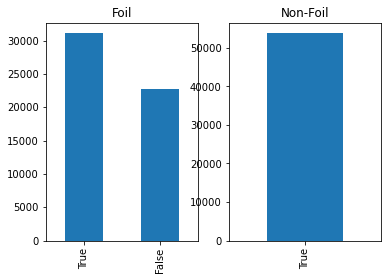

In [8]:
plt.subplot(1,2,1)
df['foil'].value_counts().plot(kind='bar', 
                                     title='Foil')
plt.subplot(1,2,2)
df['nonfoil'].value_counts().plot(kind='bar', 
                                     title='Non-Foil')

(<AxesSubplot:>,
 Mystery Booster                                1684
 Commander Legends: Battle for Baldur's Gate     838
 The List                                        812
 Commander Legends                               613
 Innistrad: Double Feature                       534
                                                ... 
 Commander 2017 Tokens                             1
 Stronghold Promos                                 1
 Pro Tour Promos                                   1
 Born of the Gods Promos                           1
 Judge Gift Cards 2012                             1
 Name: set_name, Length: 460, dtype: int64)

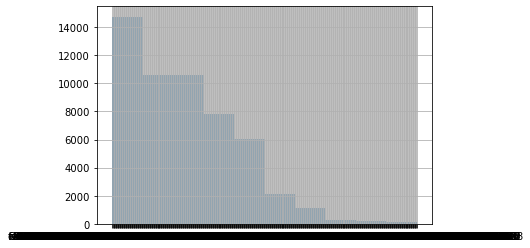

In [9]:
df['set_id'].hist(), df['set_name'].value_counts()

- How do I find out which sets were the latest printings for that card?
- How do I see which order the sets where release for multiple printing?

Plot of different rarities

(<AxesSubplot:>,
 common      20294
 rare        16059
 uncommon    14595
 mythic       2554
 special       247
 Name: rarity, dtype: int64)

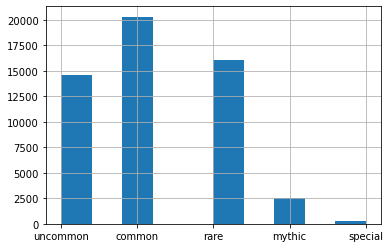

In [10]:
df['rarity'].hist(), df['rarity'].value_counts()

- 

In [11]:
train.head()

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,legalities,games,reserved,foil,nonfoil,finishes,oversized,promo,reprint,variation,set_id,set,set_name,set_type,collector_number,digital,rarity,flavor_text,artist,border_color,frame,full_art,textless,booster,story_spotlight,edhrec_rank,penny_rank,prices,promo_types,security_stamp,produced_mana,watermark,frame_effects,loyalty,printed_name,color_indicator,life_modifier,hand_modifier,content_warning,flavor_name,usd,is_foil,is_etched,is_glossy
39296,8e1e4b26-0a2b-4078-adb3-1f66315afcf5,Goblin Razerunners,en,2017-10-24,normal,True,highres_scan,{2}{R}{R},4.0,Creature — Goblin Warrior,"{1}{R}, Sacrifice a land: Put a +1/+1 counter ...",3,4,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,[nonfoil],False,False,True,False,c77df674-0ef5-47d9-ab22-56a6e1dc901c,ddt,Duel Decks: Merfolk vs. Goblins,duel_deck,47,False,rare,Finding themselves in a new and unexplored wor...,Raymond Swanland,black,2015,False,False,False,False,10400.0,9300.0,"{'usd': '0.11', 'usd_foil': None, 'usd_etched'...",no_promo,oval,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.11,False,False,False
30783,6f2fc246-2e95-456f-aa4e-97768c4f4bb4,Rites of Initiation,en,2001-10-01,normal,True,highres_scan,{R},1.0,Instant,Discard any number of cards at random. Creatur...,0,0,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,b0d90d2d-494a-4224-bfa0-36ce5ee281b1,ody,Odyssey,expansion,217,False,common,no_flavor_text,Bradley Williams,black,1997,False,False,True,False,13427.0,2777.0,"{'usd': '0.25', 'usd_foil': '3.75', 'usd_etche...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.25,True,False,False
26765,606206c7-1a8a-46f4-b368-cf18e02f3df8,Undying Flames,en,2005-06-03,normal,True,highres_scan,{4}{R}{R},6.0,Sorcery,Exile cards from the top of your library until...,0,0,[R],[R],[Epic],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,4db16ad3-2b95-442f-bb6b-e9aa7fe7f769,sok,Saviors of Kamigawa,expansion,119,False,rare,no_flavor_text,Tsutomu Kawade,black,2003,False,False,True,False,17031.0,8830.0,"{'usd': '0.30', 'usd_foil': '2.21', 'usd_etche...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.30,True,False,False
8690,1f391555-4697-4492-9854-32393f473104,Bombard,en,2018-11-16,normal,True,highres_scan,{2}{R},3.0,Instant,Bombard deals 4 damage to target creature.,0,0,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,[nonfoil],False,False,True,False,cdbedc27-4f24-4d89-ace1-8da1b36ac78e,gnt,Game Night,box,37,False,common,"""Want to sink a ship? Blow a hole in the hull....",Alex Konstad,black,2015,False,False,False,False,15067.0,7465.0,"{'usd': '0.05', 'usd_foil': None, 'usd_etched'...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.05,False,False,False
25570,5c1f3f52-cb9b-4b2a-bb02-6175897ae76e,Our Market Research Shows That Players Like Re...,en,2004-11-19,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Elemental,Art rampage 2 (Whenever this creature becomes ...,2,2,[G],[G],[],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,True,True,"[nonfoil, foil]",False,False,False,False,4c8bc76a-05a5-43db-aaf0-34deb347b871,unh,Unhinged,funny,107,False,common,Just call it OMRSTPLRLCNSWMTCTHTALCNEE for short.,Greg Hildebrandt,silver,2003,False,False,True,False,0.0,0.0,"{'usd': '0.20', 'usd_foil': '13.92', 'usd_etch...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_fra

In [12]:
train.columns

Index(['id', 'name', 'lang', 'released_at', 'layout', 'highres_image',
       'image_status', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power',
       'toughness', 'colors', 'color_identity', 'keywords', 'legalities',
       'games', 'reserved', 'foil', 'nonfoil', 'finishes', 'oversized',
       'promo', 'reprint', 'variation', 'set_id', 'set', 'set_name',
       'set_type', 'collector_number', 'digital', 'rarity', 'flavor_text',
       'artist', 'border_color', 'frame', 'full_art', 'textless', 'booster',
       'story_spotlight', 'edhrec_rank', 'penny_rank', 'prices', 'promo_types',
       'security_stamp', 'produced_mana', 'watermark', 'frame_effects',
       'loyalty', 'printed_name', 'color_indicator', 'life_modifier',
       'hand_modifier', 'content_warning', 'flavor_name', 'usd', 'is_foil',
       'is_etched', 'is_glossy'],
      dtype='object')

In [13]:
train.usd

39296      0.11
30783      0.25
26765      0.30
8690       0.05
25570      0.20
          ...  
60911      0.06
58616    175.77
1656      61.97
4195       0.29
2198       5.71
Name: usd, Length: 40311, dtype: float64

In [14]:
# use new prepare script then delete
# train['usd_foil'] = pd.to_numeric(train['usd_foil'])
# train.usd_foil

In [15]:
# train['usd'] = pd.to_numeric(train['usd'])
# train.usd

In [16]:
# foil_train = train[train["foil"]]

In [17]:
# foil_train.head()

In [18]:
# nonfoil_train = train[train["nonfoil"]]

In [19]:
# avg_nonfoil = train.groupby("set_name")['usd'].mean().dropna()

In [20]:
# # Mean of foil cards in train set
# avg_foil = train.groupby("set_name")['usd_foil'].mean().dropna()

In [21]:
# # Difference in price of nonfoils from foils in train set
# foil_diff = avg_foil - avg_nonfoil
# foil_diff

In [22]:
# foil_diff = foil_diff[foil_diff != 0]
# foil_diff

In [23]:
# foil_diff.mean()

In [24]:
# foil_vs_nonfoil =pd.concat([avg_foil, avg_nonfoil, foil_diff], axis=1)
# foil_vs_nonfoil

In [25]:
# # Remove rows with all 0s in a Dataframe
# foil_vs_nonfoil = foil_vs_nonfoil[~(foil_vs_nonfoil == 0).all(axis=1)]
# foil_vs_nonfoil

In [26]:
# foil_vs_nonfoil.columns = ['foils', 'nonfoils', 'price_difference']
# foil_vs_nonfoil

In [27]:
# def foil_vs_nonfoil_viz(df):
#     df.plot(rot=90)
#     plt.title('Difference in Average Price Between Foils and Non-Foils')
#     plt.ylabel('Avg Price')
#     plt.show()

# foil_vs_nonfoil_viz(foil_vs_nonfoil)

## What effect does frame/full art/ highres_image have on price?

In [37]:
df.watermark.value_counts(), df.border_color.value_counts()

(no_waterwark             50071
 set                        363
 mirran                     294
 phyrexian                  287
 golgari                    158
 izzet                      147
 dimir                      147
 selesnya                   143
 boros                      138
 simic                      137
 rakdos                     133
 azorius                    130
 gruul                      127
 orzhov                     122
 planeswalker               107
 sultai                      67
 foretell                    63
 temur                       60
 abzan                       60
 jeskai                      56
 conspiracy                  53
 mardu                       51
 witherbloom                 49
 dromoka                     47
 quandrix                    47
 riveteers                   46
 silumgar                    44
 ojutai                      44
 leagueofdastardlydoom       44
 obscura                     44
 brokers                     44
 maestro

In [29]:
styles = df[['frame_effects', 'border_color', 'flavor_text', 'frame', 'full_art', 'full_art', 'highres_image', 'lang', 'layout', 'promo_types', 'security_stamp', 'watermark']].copy()
styles

,frame_effects,border_color,flavor_text,frame,full_art,full_art,highres_image,lang,layout,promo_types,security_stamp,watermark
0,no_frame_effects,black,"""A rift opened, and our arrows were abruptly s...",2003,False,False,True,en,normal,no_promo,no_security_stamp,no_waterwark
1,no_frame_effects,black,"""We take only what we need to survive. Believe...",2003,False,False,True,en,normal,no_promo,no_security_stamp,no_waterwark
2,no_frame_effects,black,no_flavor_text,2015,False,False,True,en,token,[setpromo],no_security_stamp,no_waterwark
3,no_frame_effects,black,no_flavor_text,2015,False,False,True,en,normal,no_promo,no_security_stamp,no_waterwark
4,no_frame_effects,white,no_flavor_text,1993,False,False,True,en,normal,no_promo,no_security_stamp,no_waterwark
...,...,...,...,...,...,...,...,...,...,...,...,...
70927,no_frame_effects,black,"""Faith can quicken the stones themselves with ...",2015,False,False,True,en,normal,no_promo,no_security_stamp,no_waterwark
70928,no_frame_effects,white,no_flavor_text,1997,False,False,False,zhs,normal,no_promo,no_security_stamp,no_waterwark
70929,no_frame_effects,black,no_flavor_text,2003,False,False,True,en,planar,[instore],no_security_stamp,no_waterwark
70930,no_frame_effects,white,Sword hilts jut from some trolls' bodies where...,2003,False,False,True,en,normal,no_promo,no_security_stamp,no_waterwark


<AxesSubplot:title={'center':'Highres Image'}>

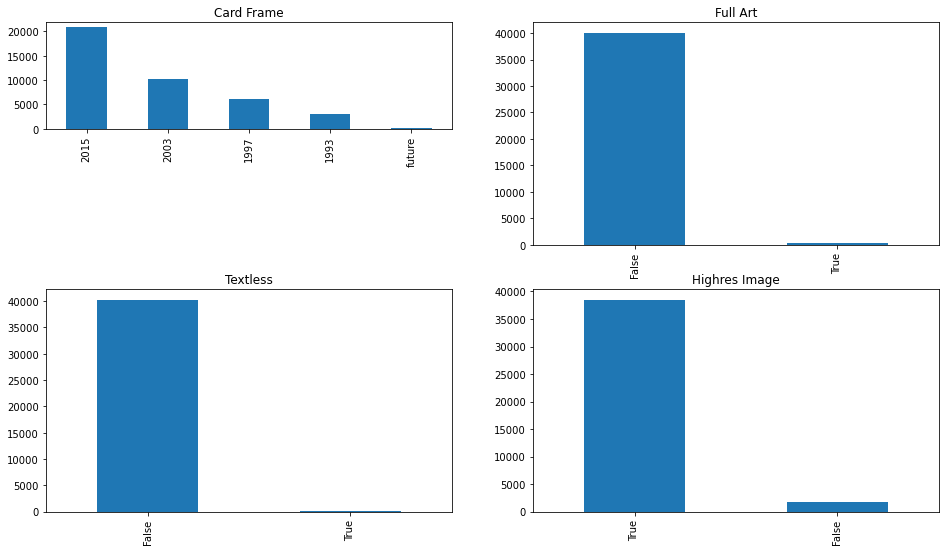

In [30]:
# Set up a grid of plots
fig = plt.figure(figsize=(16,9)) 
fig_dims = (4, 3)


# Plot accidents depending on type
plt.subplot(4, 2, 1)
train['frame'].value_counts().plot(kind='bar', 
                                     title='Card Frame')
plt.subplot(2, 2, 2)
train['full_art'].value_counts().plot(kind='bar', 
                                     title='Full Art')
plt.subplot(2, 2, 3)
train['textless'].value_counts().plot(kind='bar', 
                                     title='Textless')
plt.subplot(2, 2, 4)
train['highres_image'].value_counts().plot(kind='bar', 
                                     title='Highres Image')

In [31]:
styles['frame_effects'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


no_frame_effects                               48946
[legendary]                                     1394
[extendedart]                                    970
[inverted]                                       651
[showcase]                                       380
[legendary, extendedart]                         197
[nyxtouched]                                     183
[showcase, legendary]                            181
[sunmoondfc]                                     158
[devoid]                                         103
[tombstone]                                       89
[legendary, inverted]                             64
[colorshifted]                                    49
[snow]                                            42
[fullart]                                         29
[lesson]                                          28
[draft]                                           27
[extendedart, legendary]                          26
[miracle]                                     

In [32]:
df.loc[df['name'].str.startswith('Esika,')]

,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,legalities,games,reserved,foil,nonfoil,finishes,oversized,promo,reprint,variation,set_id,set,set_name,set_type,collector_number,digital,rarity,flavor_text,artist,border_color,frame,full_art,textless,booster,story_spotlight,edhrec_rank,penny_rank,prices,promo_types,security_stamp,produced_mana,watermark,frame_effects,loyalty,printed_name,color_indicator,life_modifier,hand_modifier,content_warning,flavor_name,usd,is_foil,is_etched,is_glossy
57457,ced8571a-24e1-45be-8698-3314b663940a,"Esika, God of the Tree // The Prismatic Bridge",en,2021-02-05,modal_dfc,True,highres_scan,no_mana_cost,3.0,Legendary Creature — God // Legendary Enchantment,no_oracle_text,0,0,no_colors,"[B, G, R, U, W]",[Vigilance],"{'standard': 'legal', 'future': 'legal', 'hist...","[arena, paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,43057fad-b1c1-437f-bc48-0045bce6d8c9,khm,Kaldheim,expansion,314,False,mythic,no_flavor_text,Collin Estrada,black,2015,False,False,False,False,23357.0,0.0,"{'usd': '6.36', 'usd_foil': '14.95', 'usd_etch...",[boosterfun],oval,"[B, G, R, U, W]",no_waterwark,"[showcase, legendary]",0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,6.36,True,False,False
68452,f6cd7465-9dd0-473c-ac5e-dd9e2f22f5f6,"Esika, God of the Tree // The Prismatic Bridge",en,2021-02-05,modal_dfc,True,highres_scan,no_mana_cost,3.0,Legendary Creature — God // Legendary Enchantment,no_oracle_text,0,0,no_colors,"[B, G, R, U, W]",[Vigilance],"{'standard': 'legal', 'future': 'legal', 'hist...","[arena, paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,43057fad-b1c1-437f-bc48-0045bce6d8c9,khm,Kaldheim,expansion,168,False,mythic,no_flavor_text,Johannes Voss,black,2015,False,False,True,False,23357.0,0.0,"{'usd': '6.46', 'usd_foil': '9.60', 'usd_etche...",no_promo,oval,"[B, G, R, U, W]",no_waterwark,[legendary],0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,6.46,True,False,False


In [33]:
util.columns_for_frame_effects_booleans(train).head()

/Users/ultimate/codeup-data-science/scratchbook_for_current_gp_proj/Jason/util.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['has_frame_effects'] = df.finishes.apply(lambda r : 'no_frame_effects' in r)


,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,legalities,games,reserved,foil,nonfoil,finishes,oversized,promo,reprint,variation,set_id,set,set_name,set_type,collector_number,digital,rarity,flavor_text,artist,border_color,frame,full_art,textless,booster,story_spotlight,edhrec_rank,penny_rank,prices,promo_types,security_stamp,produced_mana,watermark,frame_effects,loyalty,printed_name,color_indicator,life_modifier,hand_modifier,content_warning,flavor_name,usd,is_foil,is_etched,is_glossy,has_frame_effects
39296,8e1e4b26-0a2b-4078-adb3-1f66315afcf5,Goblin Razerunners,en,2017-10-24,normal,True,highres_scan,{2}{R}{R},4.0,Creature — Goblin Warrior,"{1}{R}, Sacrifice a land: Put a +1/+1 counter ...",3,4,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,[nonfoil],False,False,True,False,c77df674-0ef5-47d9-ab22-56a6e1dc901c,ddt,Duel Decks: Merfolk vs. Goblins,duel_deck,47,False,rare,Finding themselves in a new and unexplored wor...,Raymond Swanland,black,2015,False,False,False,False,10400.0,9300.0,"{'usd': '0.11', 'usd_foil': None, 'usd_etched'...",no_promo,oval,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.11,False,False,False,False
30783,6f2fc246-2e95-456f-aa4e-97768c4f4bb4,Rites of Initiation,en,2001-10-01,normal,True,highres_scan,{R},1.0,Instant,Discard any number of cards at random. Creatur...,0,0,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,b0d90d2d-494a-4224-bfa0-36ce5ee281b1,ody,Odyssey,expansion,217,False,common,no_flavor_text,Bradley Williams,black,1997,False,False,True,False,13427.0,2777.0,"{'usd': '0.25', 'usd_foil': '3.75', 'usd_etche...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.25,True,False,False,False
26765,606206c7-1a8a-46f4-b368-cf18e02f3df8,Undying Flames,en,2005-06-03,normal,True,highres_scan,{4}{R}{R},6.0,Sorcery,Exile cards from the top of your library until...,0,0,[R],[R],[Epic],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,"[nonfoil, foil]",False,False,False,False,4db16ad3-2b95-442f-bb6b-e9aa7fe7f769,sok,Saviors of Kamigawa,expansion,119,False,rare,no_flavor_text,Tsutomu Kawade,black,2003,False,False,True,False,17031.0,8830.0,"{'usd': '0.30', 'usd_foil': '2.21', 'usd_etche...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.30,True,False,False,False
8690,1f391555-4697-4492-9854-32393f473104,Bombard,en,2018-11-16,normal,True,highres_scan,{2}{R},3.0,Instant,Bombard deals 4 damage to target creature.,0,0,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,[nonfoil],False,False,True,False,cdbedc27-4f24-4d89-ace1-8da1b36ac78e,gnt,Game Night,box,37,False,common,"""Want to sink a ship? Blow a hole in the hull....",Alex Konstad,black,2015,False,False,False,False,15067.0,7465.0,"{'usd': '0.05', 'usd_foil': None, 'usd_etched'...",no_promo,no_security_stamp,no_produced_mana,no_waterwark,no_frame_effects,0,no_printed_name,no_color_indicator,0.0,0.0,False,no_flavor,0.05,False,False,False,False
25570,5c1f3f52-cb9b-4b2a-bb02-6175897ae76e,Our Market Research Shows That Players Like Re...,en,2004-11-19,normal,True,highres_scan,{1}{G}{G},3.0,Creature — Elemental,Art rampage 2 (Whenever this creature becomes ...,2,2,[G],[G],[],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,True,True,"[nonfoil, foil]",False,False,False,False,4c8bc76a-05a5-43db-aaf0-34deb347b871,unh,Unhinged,funny,107,False,common,Just call it OMRSTPLRLCNSWMTCTHTALCNEE for short.,Greg Hildebrandt,silver,2003,False,False,True,False,0.0,0.0,"{'usd': '0.20', 'usd_foil': '13.92', 'usd_etch...",no_promo,no_security_

In [34]:
# df['prices'] = df['prices'].astype(float, errors = 'raise')

In [38]:
# train['float_price'] = train['usd'] + train['usd_foil'] + train['eur'] + train['eur_foil']
# train['float_price']

In [39]:
type(df.prices)

pandas.core.series.Series

In [41]:
# # Mean of frame effect cards in train set
# train['avg_frame_effect'] = train.groupby("has_frame_effects")['float_price'].mean().dropna()
# train.head()

In [43]:
# # Mean of foil cards in train set
# avg_foil_frame = train.groupby("has_frame_effects")['usd_foil'].mean().dropna()

In [44]:
# Mean of foil cards in train set
avg_nonfoil_frame = train.groupby("has_frame_effects")['usd'].mean().dropna()

In [45]:
# # Difference in price of nonfoils from foils in train set
# frame_diff = avg_foil_frame - avg_nonfoil_frame

NameError: name 'avg_foil_frame' is not defined

In [47]:
# frame_diff.mean()

In [49]:
# # Difference in price of nonfoils from foils in train set
# foil_diff = avg_foil - avg_nonfoil
# foil_diff

In [51]:
# # Checks variance
# print(train.avg_foil_frame.var())
# print(train.avg_nonfoil_frame.var())

In [52]:
# t, p = stats.ttest_ind(train.has_frame_effects, train.prices, equal_var=False)
# t, p / 2

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:99: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [ ]:
# p / 2 < α